In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1" #model will be trained on GPU 1

In [2]:
import tensorflow.keras
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant, RandomNormal
import seaborn as sns

In [3]:
file = 'data/Hz31.txt'
data = pd.read_csv(file, names=['z', 'hz', 'err'], sep = " " )
data.describe()

,z,hz,err
count,31.000000,31.000000,31.000000
mean,0.661219,105.922581,21.303226
std,0.520398,38.413424,14.587768
min,0.070000,68.600000,4.000000
25%,0.275000,78.950000,12.000000
50%,0.470000,90.000000,17.000000
75%,0.890000,121.000000,27.900000
max,1.965000,202.000000,62.000000


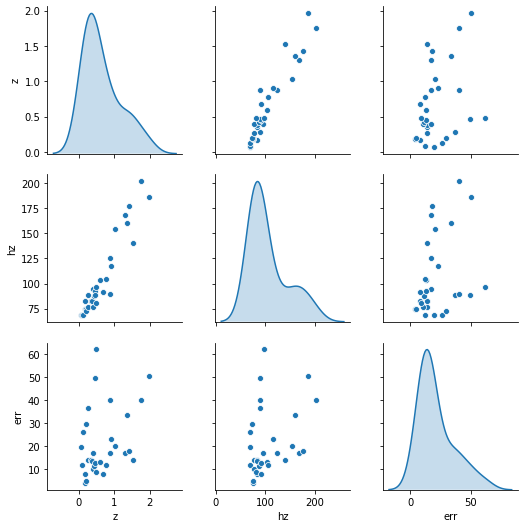

In [4]:
sns.pairplot(data, diag_kind="kde")
plt.savefig("DistHD.png")

In [5]:
# a = np.array([16, 21,  9, 15, 10,  8, 29, 17, 24, 27, 12,  0, 23, 20, 19, 3, 14,  7, 25,  4,  2,  1, 13, 18,
#   6, 26, 11, 22,  5, 30, 28])
a = np.array([25, 3, 2, 27, 14, 30, 21, 9, 8, 18, 20, 6, 22, 19, 5, 17, 4, 13, 0, 24, 29, 7, 15, 1, 12, 23, 16, 28, 10, 26, 11])
randomize = np.random.permutation(len(data.values))
data = data.values[a]

In [6]:
# def norm(x):
#     return (x - train_stats['mean']) / train_stats['std']
# normed_train_data = norm(train_dataset)
# normed_test_data = norm(test_dataset)


Read the data for cosmic chronometers

In [7]:

# odds = [x for x in range(len(data)) if x%2 ==0]
# even = [x for x in range(len(data)) if x%2 ==1]
# new_order = np.array(even+odds)
# new_order = np.array([x for x in range(len(data)-1, 0, -1)])
# data = data.values[new_order]
# data = data.values


In [8]:
z = data[:,0]
y = data[:,1:]
print(randomize)

[20 23 12 18 17  7 27 25  0 28  2  8 10 15 11  3 14  6 26 22  9 24 21 13
  4  1 16  5 29 19 30]


In [9]:
scalerz = StandardScaler()
# scalerz = MinMaxScaler(feature_range=(-1,1))
# fit scaler on data
scalerz.fit(z.reshape(-1,1))
# apply transform
z = scalerz.transform(z.reshape(-1,1))

# scalery = MinMaxScaler(feature_range=(0,1))
# scalery.fit(y)
# y = scalery.transform(y)

In [10]:
split = 0.8
ntrain = int(split * len(z))
indx = [ntrain]
z_train, z_test = np.split(z, indx)
y_train, y_test = np.split(y, indx)

In [11]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0.001,
                                   patience=50,
                                   restore_best_weights=True)]
#                      tf.keras.callbacks.ReduceLROnPlateau(patience=2)]
# initializer = Constant(value=0.01)
initializer = RandomNormal()


In [12]:
# def autoencoder(input_z):
#     #encoder
#     #input = 28 x 28 x 1 (wide and thin)
#     efirst = Dense(200, kernel_initializer=initializer, activation='relu', input_shape=(1,))(input_z)
#     ehidden = Dense(100, kernel_initializer=initializer, activation='relu')(efirst)
# #     ehidden2 = Dense(160, activation='relu')(ehidden)
# #     ehidden3 = Dense(150, activation='relu')(ehidden2)
# #     ehidden4 = Dense(100, activation='relu')(ehidden3)
#     elast = Dense(50, kernel_initializer=initializer, activation='relu')(ehidden)
#     coded = Dense(10, kernel_initializer=initializer, activation='relu')(elast)
#     #decoder 
#     dfirst = Dense(50, kernel_initializer=initializer, activation='relu')(coded)
#     dhidden = Dense(100, kernel_initializer=initializer, activation='relu')(dfirst)
# #     dhidden2 = Dense(180, kernel_initializer=initializer, activation='relu')(dhidden)
# #     dhidden3 = Dense(200, activation='relu')(dhidden2)
# #     dhidden4 = Dense(50, activation='relu')(dhidden3)
#     dlast = Dense(200, kernel_initializer=initializer, activation='relu')(dhidden)
#     decoded = Dense(2, kernel_initializer=initializer, activation='relu')(dlast)
    
#     return decoded

In [13]:
def autoencoder(input_z):
    #encoder
    #input = 28 x 28 x 1 (wide and thin)
    efirst = Dense(100, activation='relu', input_shape=(1,))(input_z)
    ehidden = Dense(50, activation='relu')(efirst)
#     ehidden2 = Dense(160, activation='relu')(ehidden)
#     ehidden3 = Dense(150, activation='relu')(ehidden2)
#     ehidden4 = Dense(100, activation='relu')(ehidden3)
    elast = Dense(50, activation='relu')(ehidden)
    coded = Dense(10, activation='relu')(elast)
    #decoder 
    dfirst = Dense(50, activation='relu')(coded)
    dhidden = Dense(50, activation='relu')(dfirst)
#     dhidden2 = Dense(180, kernel_initializer=initializer, activation='relu')(dhidden)
#     dhidden3 = Dense(200, activation='relu')(dhidden2)
#     dhidden4 = Dense(50, activation='relu')(dhidden3)
    dlast = Dense(100, activation='relu')(dhidden)
    decoded = Dense(2, activation='relu')(dlast)
    
    return decoded

In [14]:
batch_size = 4
epochs = 500
input_z = Input(shape = (1,))

In [15]:
autoencoder = Model(input_z, autoencoder(input_z))
autoencoder.compile(loss='mean_squared_error', optimizer = "adam")
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense (Dense)                (None, 100)               200       
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_4 (Dense)              (None, 50)                550       
_________________________________________________________________
dense_5 (Dense)              (None, 50)               

In [16]:
autoencoder_train = autoencoder.fit(z_train, y_train, batch_size=batch_size,
                                    epochs=epochs,verbose=1,
                                    validation_data=(z_test, y_test),
                                    callbacks=callbacks)

Epoch 1/500
6/6 [==============================] - 0s 18ms/step - loss: 6722.4941 - val_loss: 6408.2739
Epoch 2/500
6/6 [==============================] - 0s 3ms/step - loss: 6714.0649 - val_loss: 6397.0181
Epoch 3/500
6/6 [==============================] - 0s 3ms/step - loss: 6698.0020 - val_loss: 6376.0244
Epoch 4/500
6/6 [==============================] - 0s 3ms/step - loss: 6666.2383 - val_loss: 6334.2925
Epoch 5/500
6/6 [==============================] - 0s 3ms/step - loss: 6602.0405 - val_loss: 6245.7881
Epoch 6/500
6/6 [==============================] - 0s 3ms/step - loss: 6484.2544 - val_loss: 6073.2808
Epoch 7/500
6/6 [==============================] - 0s 3ms/step - loss: 6185.7910 - val_loss: 5725.3760
Epoch 8/500
6/6 [==============================] - 0s 3ms/step - loss: 5709.5762 - val_loss: 5026.5249
Epoch 9/500
6/6 [==============================] - 0s 3ms/step - loss: 4658.9194 - val_loss: 3713.9324
Epoch 10/500
6/6 [==============================] - 0s 3ms/step - loss: 

6/6 [==============================] - 0s 3ms/step - loss: 169.2630 - val_loss: 164.5307
Epoch 82/500
6/6 [==============================] - 0s 4ms/step - loss: 182.4556 - val_loss: 112.6194
Epoch 83/500
6/6 [==============================] - 0s 3ms/step - loss: 179.8289 - val_loss: 181.6349
Epoch 84/500
6/6 [==============================] - 0s 3ms/step - loss: 169.6327 - val_loss: 141.1490
Epoch 85/500
6/6 [==============================] - 0s 3ms/step - loss: 169.4719 - val_loss: 137.2986
Epoch 86/500
6/6 [==============================] - 0s 3ms/step - loss: 165.9823 - val_loss: 150.1433
Epoch 87/500
6/6 [==============================] - 0s 3ms/step - loss: 167.5894 - val_loss: 157.2057
Epoch 88/500
6/6 [==============================] - 0s 3ms/step - loss: 170.4390 - val_loss: 128.7893
Epoch 89/500
6/6 [==============================] - 0s 3ms/step - loss: 165.7837 - val_loss: 168.9003
Epoch 90/500
6/6 [==============================] - 0s 3ms/step - loss: 164.9776 - val_loss: 16

6/6 [==============================] - 0s 3ms/step - loss: 161.8916 - val_loss: 223.4725
Epoch 161/500
6/6 [==============================] - 0s 3ms/step - loss: 164.6044 - val_loss: 146.6660
Epoch 162/500
6/6 [==============================] - 0s 4ms/step - loss: 163.0963 - val_loss: 138.2327
Epoch 163/500
6/6 [==============================] - 0s 3ms/step - loss: 155.8722 - val_loss: 180.6093
Epoch 164/500
6/6 [==============================] - 0s 3ms/step - loss: 160.1338 - val_loss: 177.0770
Epoch 165/500
6/6 [==============================] - 0s 3ms/step - loss: 163.2373 - val_loss: 137.5731
Epoch 166/500
6/6 [==============================] - 0s 3ms/step - loss: 159.9229 - val_loss: 208.4849
Epoch 167/500
6/6 [==============================] - 0s 3ms/step - loss: 163.9579 - val_loss: 164.6438
Epoch 168/500
6/6 [==============================] - 0s 3ms/step - loss: 159.9639 - val_loss: 169.1708
Epoch 169/500
6/6 [==============================] - 0s 4ms/step - loss: 156.3786 - val

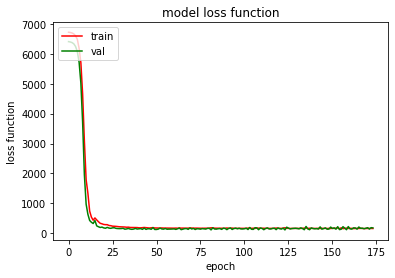

In [43]:
plt.plot(autoencoder_train.history['loss'], color='r', )
plt.plot(autoencoder_train.history['val_loss'], color='g')
plt.title('model loss function')
plt.ylabel('loss function')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("loss_ae.png")
# plt.savefig("LOSS_Overfitting_synthetic_HD.png")

In [18]:
#uncer net
unet = np.sqrt(np.min(autoencoder_train.history['val_loss']))
unet

10.550963834152302

In [19]:
pred = autoencoder.predict(z_test)
pred

array([[ 83.49821 ,  17.525492],
       [117.00461 ,  24.012547],
       [ 88.64753 ,  18.517258],
       [167.30008 ,  34.089294],
       [ 82.271866,  17.289892],
       [156.62686 ,  31.954176],
       [ 83.47277 ,  17.520596]], dtype=float32)

In [20]:
#zor and yor are the original velues for z and [Hz, err]
zor = scalerz.inverse_transform(z.reshape(-1,1))
# yor = scalery.inverse_transform(y)

In [21]:
ranz = np.random.uniform(0, 2, size=10000)
r = scalerz.transform(ranz.reshape(-1, 1))
pred_random = autoencoder.predict(r)
rr = scalerz.inverse_transform(r.reshape(-1,1))
# predy = scalery.inverse_transform(pred_random)


(0.0, 2.0)

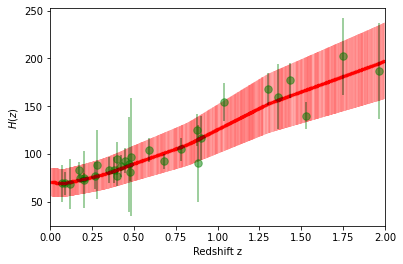

In [22]:
# plt.errorbar(zor, yor[:,0], yor[:,1], fmt='g.', markersize=15, label='Observations', alpha=0.5)
# plt.errorbar(rr, predy[:,0], predy[:,1], fmt='r.', markersize=5, label='Synthetic', alpha=0.01)
plt.errorbar(zor, y[:,0], y[:,1], fmt='g.', markersize=15, label='Observations', alpha=0.5)
plt.errorbar(rr, pred_random[:,0], pred_random[:,1], fmt='r.', markersize=5, label='Synthetic', alpha=0.01)
plt.xlabel("Redshift z")
plt.ylabel("$H(z)$")
plt.xlim(0, 2)
# plt.savefig("Overfitting_synthetic_HD.png")

In [23]:
# Cosmological constants
Om = 0.27
# variance network


In [24]:
def Hlcdm(z, H0=73.24):
    return H0 * np.sqrt(Om*(1+z)**3 + 1 - Om)

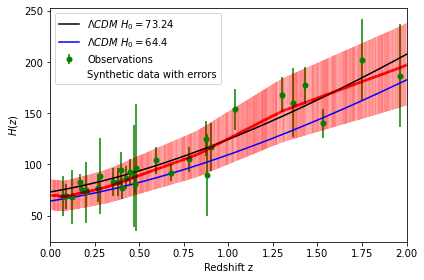

In [33]:
z = np.linspace(0, 2, 10000)
# plt.errorbar(zor, yor[:,0], yor[:,1], fmt='g.', markersize=10, label='Observations')
# plt.errorbar(rr, predy[:,0], predy[:,1], fmt='r.', markersize=4., label='Synthetic data with errors', alpha=0.01)
plt.errorbar(zor, y[:,0], y[:,1], fmt='g.', markersize=10, label='Observations')
plt.errorbar(rr, pred_random[:,0], pred_random[:,1], fmt='r.', markersize=4., label='Synthetic data with errors', alpha=0.01)

plt.plot(z, Hlcdm(z), label='$\Lambda CDM$ $H_0 = 73.24$', c='k')
plt.plot(z, Hlcdm(z, H0=64.4), label='$\Lambda CDM$ $H_0 = 64.4$', c='b')
plt.xlabel("Redshift z")
plt.ylabel("$H(z)$")
plt.xlim(0, 2)
plt.tight_layout()
plt.legend()

plt.savefig("SyntheticHDrelu.png",dpi=800)

In [26]:
pred_random.shape, r.shape

((10000, 2), (10000, 1))

In [37]:
randomselection = np.random.randint(0,1000,100)

rr_reduced = rr[randomselection,:]
# predy_reduced = predy[randomselection,:]
predy_reduced = pred_random[randomselection,:]

In [38]:
mookHz = np.concatenate((rr_reduced.reshape(-1,1), predy_reduced), axis=1)


np.savetxt("autoEncoderHz100.dat",mookHz, delimiter=" ")

In [39]:
predy_reduced[:,1]

array([35.640095, 38.20619 , 32.863235, 35.640095, 37.090324, 17.485651,
       37.19764 , 32.547634, 38.6774  , 29.230385, 32.19835 , 20.311737,
       33.223507, 34.572334, 14.877976, 26.358057, 38.086723, 30.526897,
       15.420232, 36.180298, 25.804972, 19.910746, 38.536747, 15.673556,
       35.70189 , 15.00501 , 18.795362, 18.738407, 35.85617 , 15.042209,
       34.488464, 16.168938, 33.768234, 28.883516, 22.24332 , 29.733446,
       28.265627, 17.263155, 38.17223 , 15.149898, 25.594915, 24.101194,
       34.43805 , 23.407934, 39.49963 , 15.075076, 20.181244, 34.255463,
       32.133877, 15.965816, 33.798534, 33.195213, 16.134258, 15.092913,
       17.708364, 19.75205 , 35.57051 , 19.353065, 28.719378, 31.429178,
       24.044226, 34.572334, 17.123743, 38.18251 , 16.664265, 16.794508,
       38.205994, 20.679556, 32.770958, 40.00621 , 31.406818, 36.429287,
       24.044226, 39.812035, 29.693079, 15.068769, 33.34762 , 26.698374,
       27.15972 , 15.547204, 39.273373, 16.909037, 

In [40]:
error  = predy_reduced[:,1]**2
error

array([1270.2163 , 1459.7128 , 1079.9922 , 1270.2163 , 1375.6921 ,
        305.748  , 1383.6644 , 1059.3485 , 1495.9412 ,  854.4154 ,
       1036.7336 ,  412.56665, 1103.8014 , 1195.2463 ,  221.35419,
        694.7472 , 1450.5985 ,  931.8915 ,  237.78355, 1309.0139 ,
        665.89655,  396.4378 , 1485.0808 ,  245.66037, 1274.6249 ,
        225.15031,  353.26566,  351.1279 , 1285.6649 ,  226.26804,
       1189.4542 ,  261.43454, 1140.2937 ,  834.2575 ,  494.76532,
        884.0778 ,  798.9457 ,  298.0165 , 1457.1191 ,  229.5194 ,
        655.0997 ,  580.86755, 1185.9792 ,  547.9314 , 1560.2208 ,
        227.25792,  407.2826 , 1173.4368 , 1032.586  ,  254.90727,
       1142.341  , 1101.9222 ,  260.3143 ,  227.79602,  313.58618,
        390.1435 , 1265.2612 ,  374.54114,  824.8027 ,  987.7933 ,
        578.1248 , 1195.2463 ,  293.22256, 1457.904  ,  277.69772,
        282.0555 , 1459.698  ,  427.64404, 1073.9357 , 1600.4968 ,
        986.38824, 1327.0929 ,  578.1248 , 1584.998  ,  881.67

In [41]:
diagcov = np.diag(error) #inverso
np.savetxt("autoEncoderHz_cov100.dat", diagcov, delimiter= " ", header="#50 50")
np.shape(diagcov)

(100, 100)

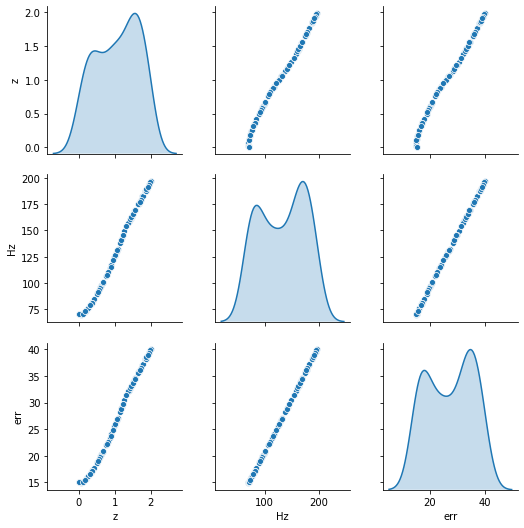

In [42]:
dfMook = pd.DataFrame(mookHz, columns=['z', 'Hz', 'err'])
sns.pairplot(dfMook, diag_kind="kde")
plt.savefig("100hdmook.png")